## Assignment for Module 5, Training Models

In this assignment you will train different models on a given data set, and find the one that performs best

### Getting the data for the assignment (similar to the notebook from chapter 2 of Hands-On...)

In [22]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [23]:
fetch_housing_data()

In [24]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [25]:
housing = load_housing_data()

### Fix the categories in the categorical variable

In [26]:
d = {'<1H OCEAN':'LESS_1H_OCEAN', 'INLAND':'INLAND', 'ISLAND':'ISLAND', 'NEAR BAY':'NEAR_BAY', 'NEAR OCEAN':'NEAR_OCEAN'}
housing['ocean_proximity'] = housing['ocean_proximity'].map(lambda s: d[s])

### Add 2 more features

In [27]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["population_per_household"]=housing["population"]/housing["households"]

### Fix missing data

In [28]:
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True) 

### Create dummy variables based on the categorical variable

In [29]:
one_hot = pd.get_dummies(housing['ocean_proximity'])
housing = housing.drop('ocean_proximity', axis=1)
housing = housing.join(one_hot)

### Check the data

In [30]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 16 columns):
longitude                   20640 non-null float64
latitude                    20640 non-null float64
housing_median_age          20640 non-null float64
total_rooms                 20640 non-null float64
total_bedrooms              20640 non-null float64
population                  20640 non-null float64
households                  20640 non-null float64
median_income               20640 non-null float64
median_house_value          20640 non-null float64
rooms_per_household         20640 non-null float64
population_per_household    20640 non-null float64
INLAND                      20640 non-null uint8
ISLAND                      20640 non-null uint8
LESS_1H_OCEAN               20640 non-null uint8
NEAR_BAY                    20640 non-null uint8
NEAR_OCEAN                  20640 non-null uint8
dtypes: float64(11), uint8(5)
memory usage: 1.8 MB


# ASSIGNMENT

### 1. Partition into train and test

Use train_test_split from sklearn.model_selection to partition the dataset into 70% for training and 30% for testing.

You can use the 70% for training set as both training and validation by using cross-validation.


In [31]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

### Features

In [32]:
target = 'median_house_value'
features = list(train_set.columns)
features = [f for f in features if f!=target]

In [33]:
X_tr = train_set[features]
y_tr = train_set[[target]]

X_te = test_set[features]
y_te = test_set[[target]]

### 2. Polynomial transformations

Use PolynomialFeatures from sklearn.preprocessing

In [34]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
poly.fit(X_tr)
X_tr = poly.fit_transform(X_tr)
X_te = poly.transform(X_te)

##### You should obtain X_tr and X_te with 136 columns each, since originally you had 15 features.

##### With m original features, the new added polynomial features of degree 2 are: $(m^2-m)/2+m+1$. Why?

##### These, plus the original features gives a total of  $(m^2-m)/2+2m+1$

In [35]:
print("Original number of features: "+str(len(features)))
print("Final number of features: "+str(X_tr.shape[1]))

Original number of features: 15
Final number of features: 136


In [36]:
import numpy as np
array_of_features = np.array(features)
feature_names_transformed = poly.get_feature_names(array_of_features)
#feature_names_transformed

### 3. Scaling features

In [37]:
#Capture the categorical indexes - 'INLAND^2', 'ISLAND^2', 'LESS_1H_OCEAN^2', 'NEAR_BAY^2', 'NEAR_OCEAN^2', 'INLAND', 
#                                  'ISLAND', 'LESS_1H_OCEAN', 'NEAR_BAY', 'NEAR_OCEAN',INLAND ISLAND','INLAND LESS_1H_OCEAN',
#                                  'INLAND NEAR_BAY', 'INLAND NEAR_OCEAN', 'ISLAND LESS_1H_OCEAN', 'ISLAND NEAR_BAY',
#                                  'ISLAND NEAR_OCEAN', 'LESS_1H_OCEAN NEAR_BAY', 'LESS_1H_OCEAN NEAR_OCEAN',
#                                  'NEAR_BAY NEAR_OCEAN',

#Capture all the categorical features in a list.

X_tr_Categorical = ['INLAND', 'ISLAND', 'LESS_1H_OCEAN', 'NEAR_BAY', 'NEAR_OCEAN','INLAND^2','INLAND ISLAND',
                    'INLAND LESS_1H_OCEAN', 'INLAND NEAR_BAY', 'INLAND NEAR_OCEAN', 'ISLAND^2','ISLAND LESS_1H_OCEAN', 
                    'ISLAND NEAR_BAY','ISLAND NEAR_OCEAN','LESS_1H_OCEAN^2','LESS_1H_OCEAN NEAR_BAY', 
                    'LESS_1H_OCEAN NEAR_OCEAN', 'NEAR_BAY^2', 'NEAR_BAY NEAR_OCEAN','NEAR_OCEAN^2']


X_tr_Categorical_index_ = [feature_names_transformed.index(item) for item in X_tr_Categorical]

#indexes = [11, 12, 13, 14, 15, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135]

#Get the overall index.

X_tr_Total_index_ = [i for i in range(0,136)]

#The Non Categorical index = Overall indexes - Categorical models.
X_tr_Non_Categorical_index_ = list(pd.DataFrame(X_tr).drop(X_tr_Categorical_index_, axis = 1))

Similarly, use StandardScaler from sklearn.preprocessing to normalize the training and testing data, using the training data

In [38]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(X_tr_Non_Categorical_index_)),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(X_tr_Categorical_index_))
    ])


from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),    
    
    ])

# Convert the X_tr and X_te lists into DataFrames, before transforming the data.
X_tr = pd.DataFrame(X_tr)
X_te = pd.DataFrame(X_te)

X_train_transform = full_pipeline.fit_transform(X_tr)
X_test_transform = full_pipeline.transform(X_te)

# Apply Poly transformations on the y_tr and y_te DataFrames
from sklearn.preprocessing import StandardScaler

number_pipeline = Pipeline([('std_scaler', StandardScaler())])

Y_train_transform = number_pipeline.fit_transform(y_tr)
Y_test_transform = number_pipeline.transform(y_te)

#### Comparing models

In [39]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import numpy as np

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())

### 4. Linear regression on original features (no transformations) --- benchmark

#### Your goal is to find the model that minimizes the rmse score

In [40]:
from sklearn.linear_model import LinearRegression
lin_scores = cross_val_score(LinearRegression(), train_set[features], train_set[target], scoring="neg_mean_squared_error", cv=5)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [ 68683.53354619  67495.9832021   67843.66049759  67550.28755245
  71279.16472374]
Mean: 68570.5259044


### 5. Linear regression  (on transformed features: polynomial transformation + scaling)

Now do as in 4 but with the original and transformed features (136 features)

In [41]:
from sklearn.linear_model import LinearRegression
lin_scores = cross_val_score(LinearRegression(),X_train_transform,Y_train_transform, scoring="neg_mean_squared_error", cv=5) ## YOUR CODE HERE ##
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [  1.16471372e+09   1.69675537e+00   1.38133004e+10   5.38730771e+07
   4.28471095e+09]
Mean: 3863319629.61


If the error on the cross-validation is too high it is because the model is over-fitting. Regularization is needed.

### 6. Ridge regression

In [42]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import Ridge
param_grid = [{'alpha': [0.001,0.01,0.1,1,10,100,1000,1000]}]
grid_search_rr = GridSearchCV(Ridge(), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search_rr.fit(X_tr, y_tr)

GridSearchCV(cv=3, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [43]:
print(grid_search_rr.best_params_)
print(np.sqrt(-grid_search_rr.best_score_))

{'alpha': 1000}
521772.344771


### 7. Lasso regression

Now do the same as in 6 but with Lasso

In [44]:
from sklearn.linear_model import Lasso
param_grid = [{'alpha': [0.001,0.01,0.1,1,10,100,1000,1000]}]
grid_search_lasso = GridSearchCV(Lasso(), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search_lasso.fit(X_train_transform, Y_train_transform)

GridSearchCV(cv=3, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [45]:
print(grid_search_lasso.best_params_)
print(np.sqrt(-grid_search_lasso.best_score_))

{'alpha': 0.01}
0.577176637229


### 8. Elastic Net regression

Do the same as in 6 and 7, but now with Elastic Net. However, the grid search should be over the parameters alpha and  l 1ratio. Use just 3 values for l1_ratio.

In [46]:
from sklearn.linear_model import ElasticNet

param_grid = [{'alpha': [0.001,0.01,0.1,1,10,100,1000], 'l1_ratio' : [0, 0.5, 1]}] 
grid_search_elastic_net = GridSearchCV(ElasticNet(), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search_elastic_net.fit(X_train_transform, Y_train_transform)

GridSearchCV(cv=3, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'l1_ratio': [0, 0.5, 1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [47]:
print(grid_search_elastic_net.best_params_)
print(np.sqrt(-grid_search_elastic_net.best_score_))

{'alpha': 0.01, 'l1_ratio': 0.5}
0.567844697997


### Evaluating your best model on TESTING data

Choose among grid_search_rr, grid_search_lr, and grid_search_enr, the model with best performance

In [54]:
from sklearn.metrics import mean_squared_error

final_model = grid_search_elastic_net.best_estimator_   ## grid_search SHOULD BE THE BEST GRID SEARCH ##

y_test_estimation = final_model.predict(X_test_transform)

# Standardize y_te_estimation

y_test_estimation_transform = y_test_estimation.reshape(-1, 1)

final_mse = mean_squared_error(Y_test_transform, y_test_estimation_transform)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

0.581670270759


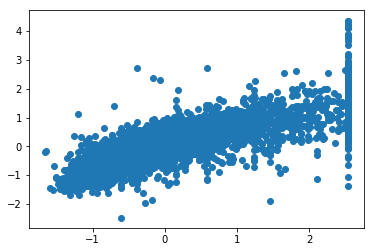

In [49]:
import matplotlib.pyplot as plt

plt.scatter(x=Y_test_transform, y=y_test_estimation_transform)
plt.show()

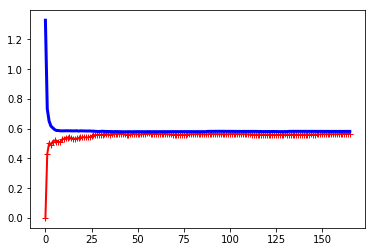

In [50]:
# Let's graph the learning curves on the best model

Elastic_net = ElasticNet(alpha = 0.01, l1_ratio = 0.5)

#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
train_errors, val_errors = [], []
for m in range(1, len(X_train_transform), 100):
    mth_X_train_transform = X_train_transform[:m]
    Elastic_net.fit(mth_X_train_transform, Y_train_transform[:m])
    y_train_predict = Elastic_net.predict(X_train_transform[:m])
    y_val_predict = Elastic_net.predict(X_test_transform)
    train_errors.append(mean_squared_error(y_train_predict, Y_train_transform[:m]))
    val_errors.append(mean_squared_error(y_val_predict, Y_test_transform))

plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
plt.show()

### Question: Before you computed the final_rmse on the test data, what was your expected value for this quantity? Does your best model have high variance?

##### YOUR ANSWER HERE 

It seems that our final Elastic Net model fits the housing data nicely as the rmse on the training data is 0.5678 and the rmse on the testing data is 0.5816. Also Elastic Net, seems to have have a minimal amout of variance as can be seen from the graph above.

#[Optional]
Why does the matrix X appears transponsed in the normal equation in the linear regression? Equation 4.4. Start from equation 4.3



Let's rewrite the MSE cost function for a Linear Regression model in a matrix notation:

$$J(\theta) = \frac{1}{2m} (X \theta  - y)^T(X \theta - y)$$

$$J(\theta) = \frac{1}{2m} ((X \theta)^T - y^T)(X \theta - y)$$
$$J(\theta) = \frac{1}{2m} ((X \theta)^T X \theta - (X \theta)^T y - y^T (X \theta) + y^Ty)$$
$$J(\theta) = \frac{1}{2m} (\theta^T X^T X \theta - 2(X \theta)^T y + y^Ty)$$
$$\frac{\partial J}{\partial \theta} = 2 X^T X \theta  - 2X^T y = 0$$
$$ X^T X \theta = X^T y$$
$$ \hat\theta = (X^T X)^{-1}X^Ty$$

#[Optional]
Do all Gradient Descent algorithms lead to the same model provided you let them run long enough?



If the optimization problem is convex (such as Linear Regression or Logistic Regression), and assuming the learning rate is not too high, then all Gradient Descent algorithms will approachthe global optimum and end up producing fairly similar models. Howere, unless you gradually reduce the learning rate, Stochastic GD and Mini-Batch GD will never truly converge; instead, they will keep jumping back and forth around the global optimum. This means that even if you let them run for a very long time, these Gradient Descent algorithms will produce slightly different models

#[Optional]
Is it a good idea to stop Mini-batch Gradient Descent immediately when the validation error goes up?



Due to their random nature, neither Stochastic Gradient Descent nor Mini-Batch Gradient Descent is guaranteed to make progress at every single iteration. So, if you immediately stop training when the validation error goes up, you may stop much too early, before the optimum is reached. A better option is to save the model at regular intervals, and when it has not improved for a long time (meaning it will probably never beat the record), you can revert to the best saved model.

#[Optional]
Suppose you are using Ridge Regression and you notice that the training error and the validation error are almost equal and fairly high. Would you say that the model suffers from high bias or high variance? Should you increase the regularization hyperparameter α or reduce it?



If both the training error and the validation error are almost equal and fairly high, the model is likely underfitting the training set, which means it has a high bias. We should try reducing the regularization hyperparameter $\alpha$.

#[Optional]
Why does the matrix X appears transponsed in the normal equation in the linear regression? Equation 4.4. Start from equation 4.3



Let's rewrite the MSE cost function for a Linear Regression model in a matrix notation:

$$J(\theta) = \frac{1}{2m} (X \theta  - y)^T(X \theta - y)$$

$$J(\theta) = \frac{1}{2m} ((X \theta)^T - y^T)(X \theta - y)$$
$$J(\theta) = \frac{1}{2m} ((X \theta)^T X \theta - (X \theta)^T y - y^T (X \theta) + y^Ty)$$
$$J(\theta) = \frac{1}{2m} (\theta^T X^T X \theta - 2(X \theta)^T y + y^Ty)$$
$$\frac{\partial J}{\partial \theta} = 2 X^T X \theta  - 2X^T y = 0$$
$$ X^T X \theta = X^T y$$
$$ \hat\theta = (X^T X)^{-1}X^Ty$$